In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp
from scipy.integrate import cumulative_simpson as cumsimp
from scipy.linalg import cholesky, solve_triangular, solve



In [2]:
import dickandballs as db

In [3]:
x2 = np.linspace(7.596e-02, 50, 50) # my number density, starting val is ending val of n crust
#x2 = np.logspace(np.log10(n_crust[-1]), np.log10(50) , 50) # logspace from final value of crust number density to 50, note logspace uses base10

x1 = np.array([1,40])
cs2_1 = (np.array([0.033545,1/3]))
f1 = -np.log(1/cs2_1 - 1)

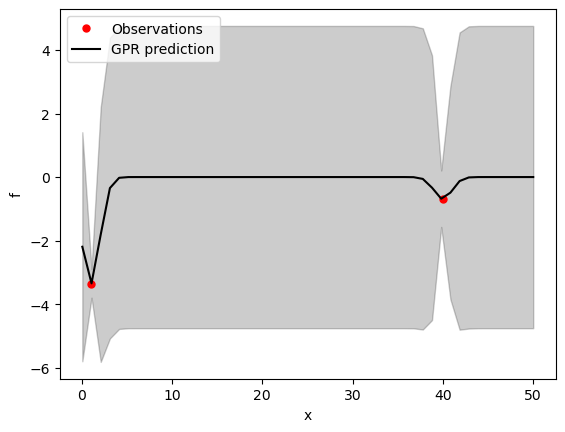

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# the squared exponential kernel is RBF kernel
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel=kernel)
# fit the model to the residuals
gpr.fit(x1.reshape(-1, 1), f1.reshape(-1, 1))

f2, sigma = gpr.predict(x2.reshape(-1,1), return_std=True)

plt.figure()
plt.plot(x1, f1, 'r.', markersize=10, label='Observations')
plt.plot(x2, f2, '-', color='black', label='GPR prediction')
plt.fill_between(x2.ravel(), f2 - 1.96 * sigma, f2 + 1.96 * sigma, alpha=0.2, color='k')
plt.xlabel('x')
plt.ylabel('f')
plt.legend()
plt.show()

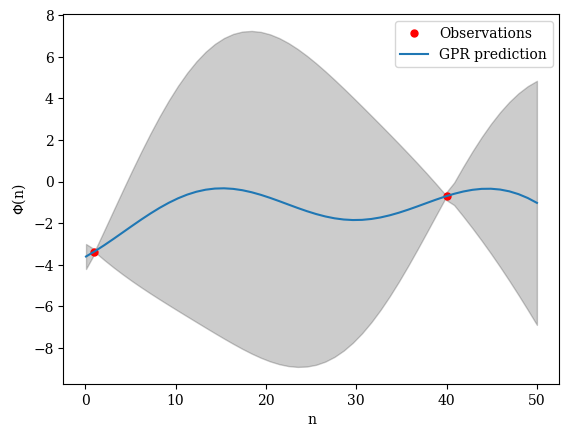

In [67]:
my_kernel = db.Kernel('SE', sigma=5, l=15)

my_gp = db.GP(my_kernel, -np.log(1/(0.72) - 1))

my_gp.fit(x1,x2,f1)

n = 1
y, sig = my_gp.posterior(n) # y is the phi


plt.figure()
plt.plot(x1, f1, 'r.', markersize=10, label='Observations')
for i in range(n):
    plt.plot(x2, y[i], label=f'GPR prediction' if i == 0 else "")
 
plt.fill_between(x2.ravel(), y[0] - 1.96 * sig, y[0] + 1.96 * sig, alpha=0.2, color='k')

plt.rcParams["font.family"] = "serif"
plt.xlabel('n')
plt.ylabel(r'$\Phi$(n)')
plt.legend()
plt.show()

# crust + eos properties

In [6]:
crust_eos= np.loadtxt('EOS/crust/crust_eos.dat')
n_crust, e_crust, p_crust, cs2_crust = crust_eos.T # unpacking the data into separate arrays

In [7]:
n_crust

array([2.720e-14, 1.270e-13, 6.930e-13, 6.295e-12, 1.581e-11, 3.972e-11,
       9.976e-11, 2.506e-10, 6.294e-10, 1.581e-09, 3.972e-09, 5.000e-09,
       9.976e-09, 1.990e-08, 3.973e-08, 7.926e-08, 1.581e-07, 1.991e-07,
       3.156e-07, 5.001e-07, 6.296e-07, 9.667e-07, 1.532e-06, 2.507e-06,
       3.974e-06, 4.830e-06, 6.081e-06, 7.930e-06, 9.982e-06, 1.257e-05,
       1.522e-05, 1.991e-05, 2.507e-05, 2.791e-05, 3.807e-05, 5.063e-05,
       6.592e-05, 8.433e-05, 1.062e-04, 1.321e-04, 1.624e-04, 1.690e-04,
       1.759e-04, 1.830e-04, 1.902e-04, 1.977e-04, 2.054e-04, 2.079e-04,
       2.082e-04, 2.091e-04, 2.160e-04, 2.231e-04, 2.311e-04, 2.401e-04,
       2.500e-04, 2.643e-04, 3.053e-04, 3.533e-04, 4.076e-04, 4.680e-04,
       5.341e-04, 6.059e-04, 7.661e-04, 1.262e-03, 1.895e-03, 2.673e-03,
       3.606e-03, 4.710e-03, 7.496e-03, 1.120e-02, 1.600e-02, 2.207e-02,
       2.948e-02, 4.268e-02, 6.220e-02, 7.317e-02, 7.596e-02])

In [54]:
epsi_ini = e_crust[-1]
p_ini = p_crust[-1]
n_ini = n_crust[-1]
mu_ini = (epsi_ini + p_ini) / n_ini
mu_crust_0 = (e_crust[0] + p_crust[0]) / n_crust[0]

### getting the properties

In [9]:
eos_props = db.EosProperties(x2, y.reshape(-1), epsi_ini, p_ini, mu_ini)
eos_prop_results = eos_props.get_all()

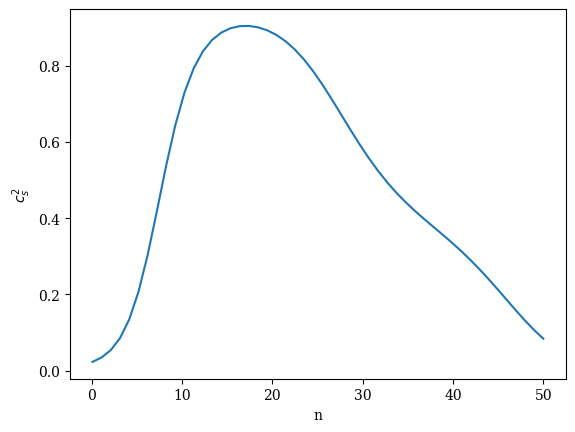

In [10]:
plt.plot(x2, eos_prop_results["cs2"])
plt.xlabel('n')
plt.ylabel(r'$c_s^2$')
plt.show()

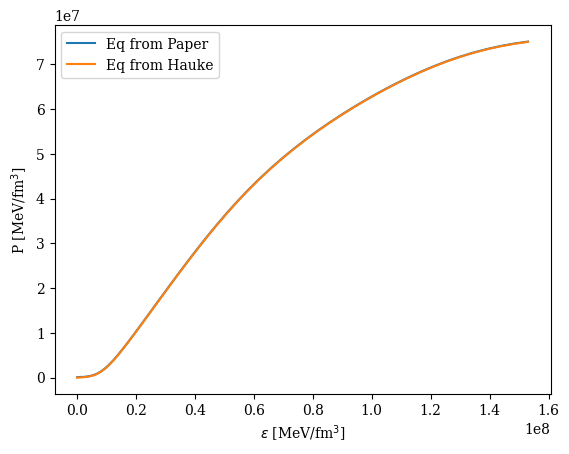

In [11]:
plt.plot(eos_prop_results["epsilon"], eos_prop_results["pressure1"], label="Eq from Paper")
plt.plot(eos_prop_results["epsilon"], eos_prop_results["pressure2"], label="Eq from Hauke")
plt.xlabel(r"$\epsilon$ [MeV/fm$^3$]")
plt.ylabel("P [MeV/fm$^3$]")
plt.legend()
plt.show()

In [12]:
eos_prop_results["pressure1"][:3]

array([ 68758.96188377, 142067.59790851, 141755.5375795 ])

In [13]:
eos_prop_results["pressure2"][:3]

array([6.74250156e-01, 2.89649791e+04, 7.65413817e+04])

# hyperparemeter sampling

In [14]:
def get_hype_samples():
    
    rng = np.random.default_rng()
    cs2_hat = rng.normal(0.5,0.25**2)
    l = rng.normal(1, 0.25**2)
    nu = rng.normal(1.25, 0.2**2)

    return cs2_hat, l, nu

def get_phi(cs2):
    return -np.log(1/cs2 - 1)

In [62]:
x_test = np.linspace(7.596e-02, 50, 50) # my number density, starting val is ending val of n crust

x_train = np.array([1,40])
cs2_train = (np.array([0.033545,1/3]))
phi_train = get_phi(cs2_train)

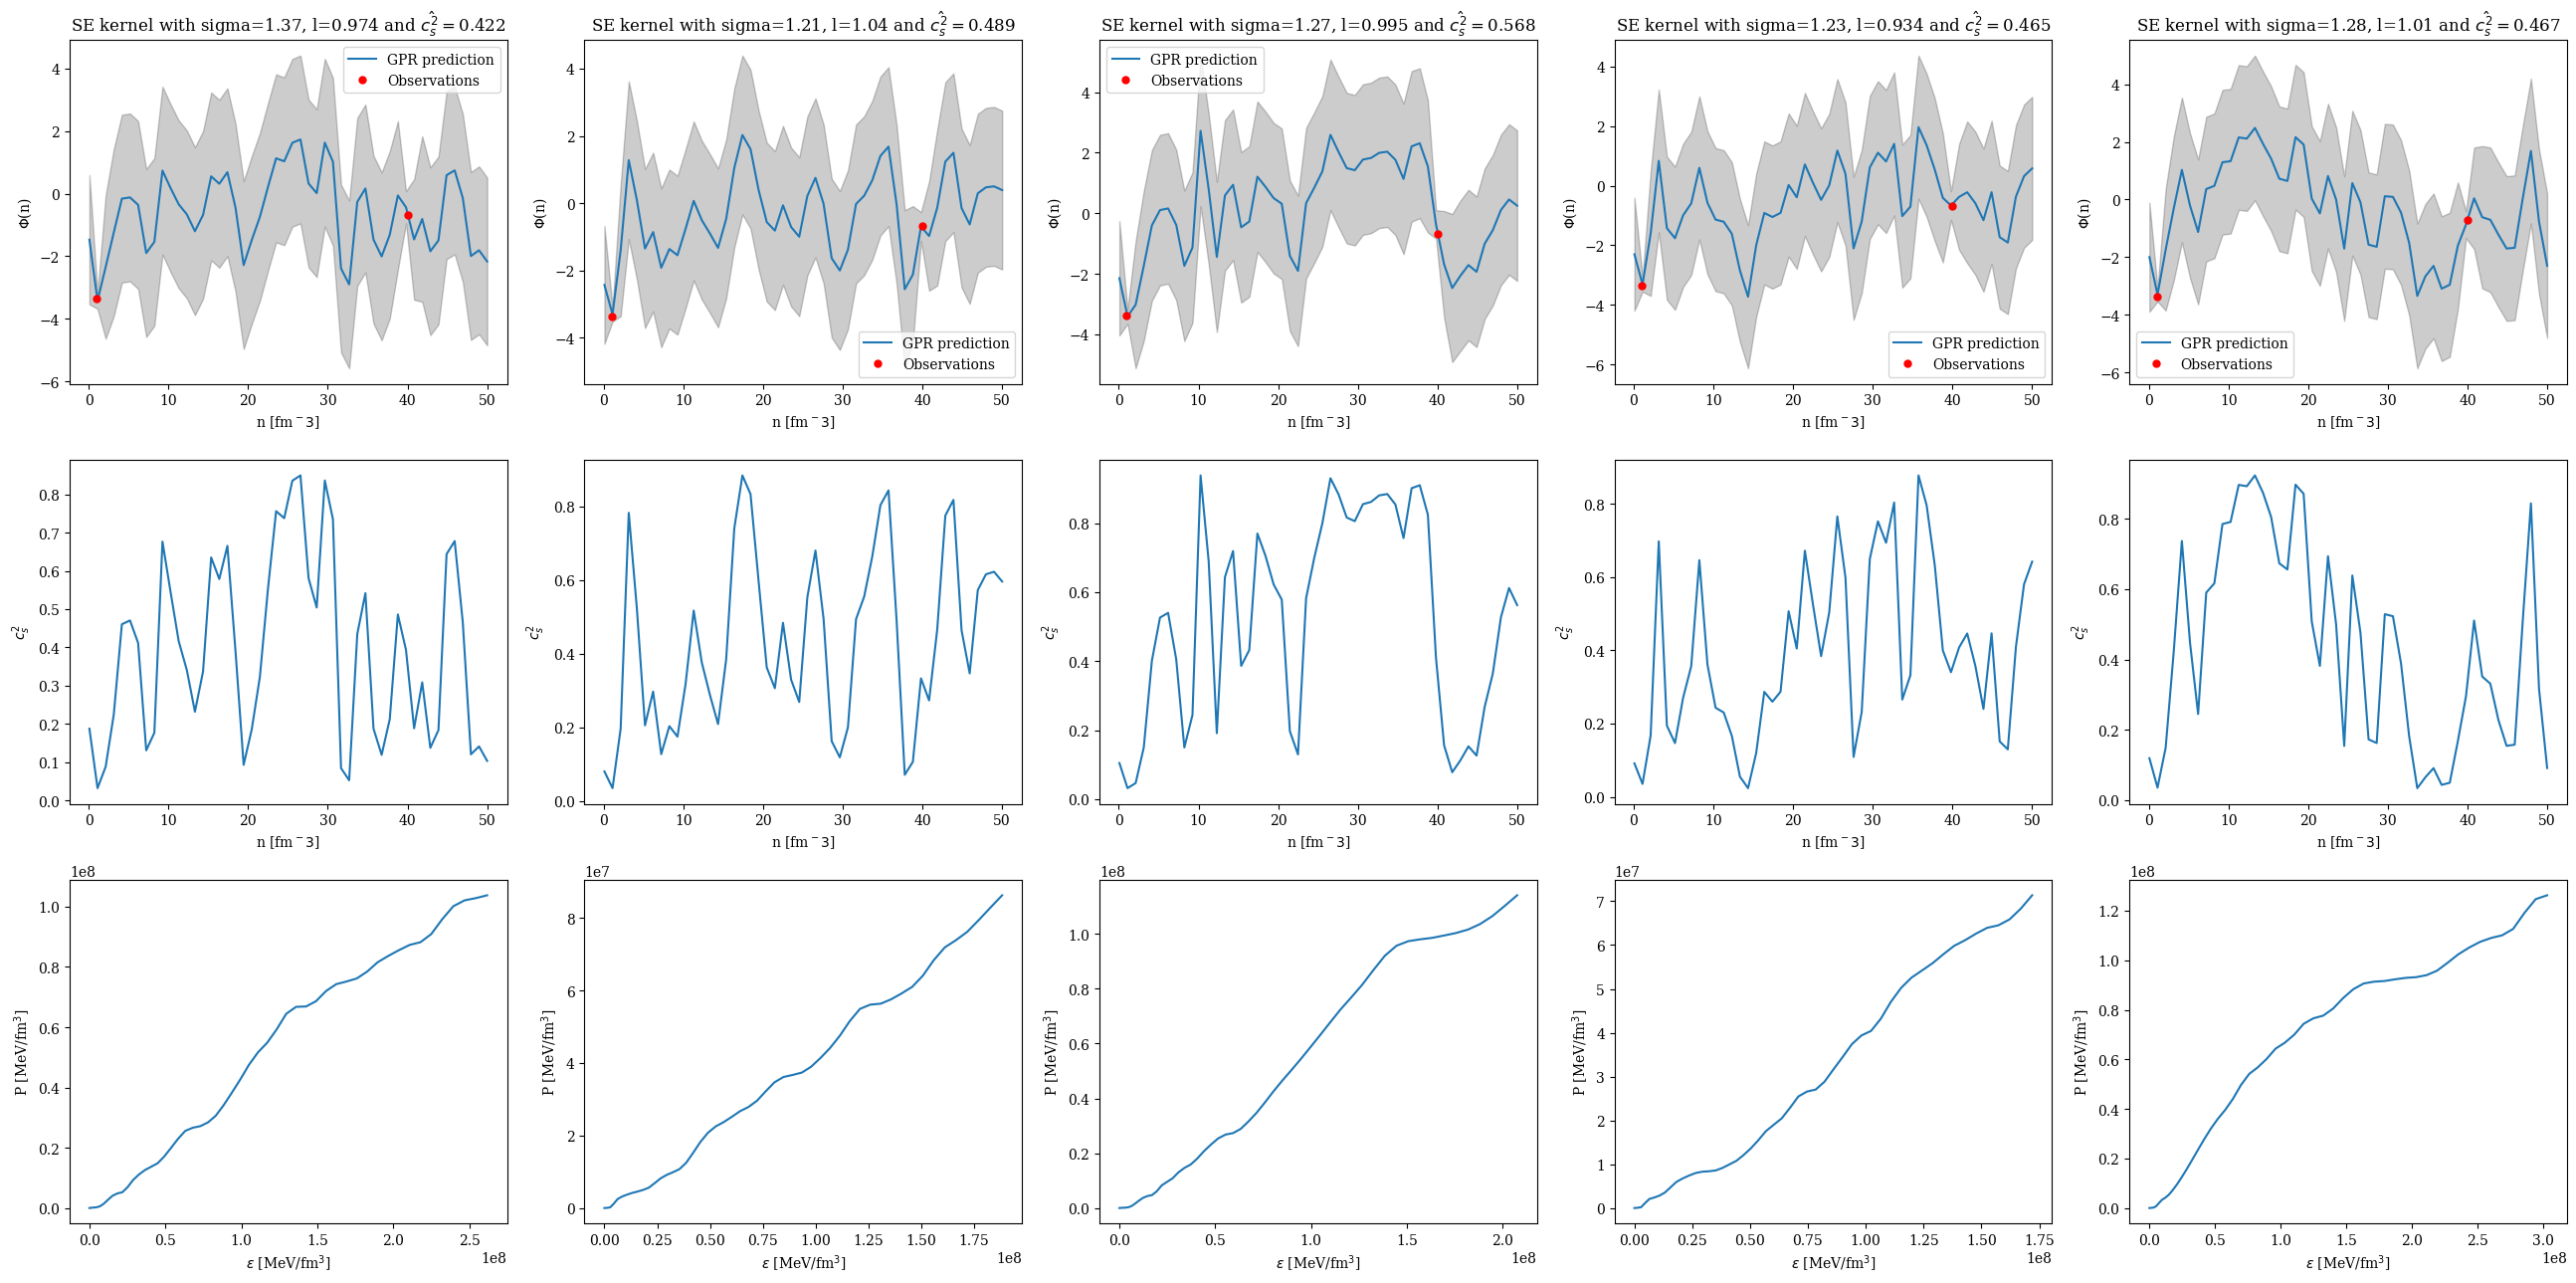

In [66]:
fig, axs = plt.subplots(3, 5, figsize=(26, 13))

for i in range(5):
    cs2_hat, l_hat, nu_hat = get_hype_samples()
    kernel = db.Kernel('SE', sigma=nu_hat, l=l_hat)
    gp = db.GP(kernel, get_phi(cs2_hat))
    
    gp.fit(x_train,x_test,phi_train)

    phi_test, sig = gp.posterior()

    eos_props = db.EosProperties(x_test, phi_test.reshape(-1), epsi_ini, p_ini, mu_ini)
    eos_prop_results = eos_props.get_all()

    # Plot cs2 vs n in the top row
    axs[0, i].plot(x_test, phi_test[0], label=f'GPR prediction')
    axs[0, i].plot(x_train, phi_train, 'r.', markersize=10, label='Observations')
    axs[0,i].fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.2, color='k')
    axs[0, i].set_xlabel('n [fm$^-3$]')
    axs[0, i].set_ylabel(r'$\Phi$(n)')
    axs[0, i].legend()

    formatted_params = ', '.join([f'{key}={value:.3g}' for key, value in kernel.params.items()])
    title_str = f'{kernel.kernel_type} kernel with {formatted_params} and ' + r'$\hat{c_s^2}=$' + f'{cs2_hat:.3g}'
    axs[0, i].set_title(title_str)


    axs[1, i].plot(x_test, eos_prop_results['cs2'])
    axs[1, i].set_xlabel('n [fm$^-3$]')
    axs[1, i].set_ylabel(r'$c_s^2$')

    # Plot epsi vs p in the bottom row
    axs[2, i].plot(eos_prop_results['epsilon'], eos_prop_results['pressure2'])
    axs[2, i].set_xlabel(r"$\epsilon$ [MeV/fm$^3$]")
    axs[2, i].set_ylabel('P [MeV/fm$^3$]')

plt.rcParams["font.family"] = "serif"
plt.tight_layout()
plt.show()

and other kernels + white noise kernel, and add functionality to add and multiply kernels.